# Brazillian E-commerce Olist Dataset

## Objetivos

Vamos estabelecer três objetivos para esse _notebook_, sendo dois deles de análise e geração de _insights_, e um último de predição.
São eles os seguintes:

- visualização geográfica sobre três variáveis - número de compras/vendas, gasto/captação, tempo de entrega;
- análise exploratória sobre as mesmas;
- se possível, treinar um modelo para predição de tempo de entrega.  

# 0.0 SETUP

## 0.1 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as ss
import geopy.distance
from sklearn.linear_model import LinearRegression

## 0.2 HELPER FUNCTIONS

In [2]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [3]:
def get_sum_per_value(value_array, value_type, target_variable, df):

    sum_per_value_array = []

    for value in value_array:

        aux_df = df.loc[df[value_type] == value]
        sum = np.sum(aux_df[target_variable])
        sum_per_value_array.append(sum)

    return sum_per_value_array    

def assemble_customers_df(df):

    bought_itens_count_per_order_array = []
    total_cost_per_order_array = []

    for order_id in df['order_id']:

        customer_df = olist_order_items_dataset1.loc[olist_order_items_dataset1['order_id'] == order_id]
        
        bought_itens_count = customer_df.shape[0]
        total_cost = np.sum(customer_df['price'].values)
        
        bought_itens_count_per_order_array.append(bought_itens_count)
        total_cost_per_order_array.append(total_cost)
    
    bought_itens_count_df = pd.Series(bought_itens_count_per_order_array, name='bought_items_count')    
    total_cost_df = pd.Series(total_cost_per_order_array, name='total_cost')    
    
    df = pd.concat([df, bought_itens_count_df, total_cost_df], axis=1)
    
    return df

def assemble_order_id(olist_customers_dataset1, olist_orders_dataset1):

    order_id_array = []

    for customer_id in olist_customers_dataset1['customer_id'].values:

        customer_id_row = olist_orders_dataset1.loc[olist_orders_dataset1['customer_id'] == customer_id].iloc[0]
        order_id = customer_id_row['order_id']

        order_id_array.append(order_id)
        
    order_id_df = pd.Series(order_id_array, name='order_id')
    olist_customers_dataset1 = pd.concat([olist_customers_dataset1, order_id_df], axis=1)
    
    return olist_customers_dataset1

def assemble_geolocation(df, zip_column, olist_geolocation_dataset1):

    geolocation_lat_array = []
    geolocation_lng_array = []

    
    for zip_code_prefix in df[zip_column].values:       
        try:
            geolocation_row = olist_geolocation_dataset1.loc[olist_geolocation_dataset1['geolocation_zip_code_prefix'] == zip_code_prefix].iloc[0]
            geolocation_lat = geolocation_row['geolocation_lat']
            geolocation_lng = geolocation_row['geolocation_lng']            
            
        except IndexError:
            geolocation_lat = 0.
            geolocation_lng = 0.

        geolocation_lat_array.append(geolocation_lat)
        geolocation_lng_array.append(geolocation_lng)

    geolocation_lat_df = pd.DataFrame(geolocation_lat_array)
    geolocation_lat_df.columns = ['geolocation_lat']
    
    geolocation_lng_df = pd.DataFrame(geolocation_lng_array)
    geolocation_lng_df.columns = ['geolocation_lng']

    df = pd.concat([df, geolocation_lat_df, geolocation_lng_df], axis=1)
    
    return df

def assemble_sellers_df(olist_sellers_dataset1):
    
    sold_itens_count_per_seller_array = []
    total_income_per_seller_array = []   
    
    for seller_id in olist_sellers_dataset1['seller_id'].values:
    
        seller_df = olist_order_items_dataset1.loc[olist_order_items_dataset1['seller_id'] == seller_id]
        
        sold_itens_count = seller_df.shape[0]
        total_income = np.sum(seller_df['price'].values)
        
        sold_itens_count_per_seller_array.append(sold_itens_count)
        total_income_per_seller_array.append(total_income)    
    
    sold_itens_count_df = pd.DataFrame(sold_itens_count_per_seller_array)
    sold_itens_count_df.columns = ['sold_items_count']
    
    total_income_df = pd.DataFrame(total_income_per_seller_array)
    total_income_df.columns = ['total_income']
    
    olist_sellers_dataset1 = pd.concat([olist_sellers_dataset1, sold_itens_count_df, total_income_df], axis=1)
    
    return olist_sellers_dataset1

def check_nans(df_column):    
    
    lista = df_column.isnull().values.tolist()
    count = sum((x is not False for x in lista))
    
    return count

def assemble_data_description_table(df):

    c1 = pd.DataFrame([df.name]*len(df.columns))
    c2 = pd.DataFrame([df.shape[0]]*len(df.columns))
    c3 = pd.DataFrame(df.columns)
    c4 = pd.DataFrame(df.dtypes.values)    
    c5 = pd.DataFrame(df.apply(check_nans))
    c5 = pd.DataFrame(c5.iloc[:,-1:].values)
    
    data_description_table = pd.concat([c1, c2, c3, c4, c5], axis=1)
    data_description_table.columns = ['dataset_name', 'rows_number', 'var_name', 'dtype', 'nans_number']

    return data_description_table

def get_data_description_tables():

    df_list = [olist_customers_dataset_raw, 
    olist_geolocation_dataset_raw, 
    olist_order_items_dataset_raw,
    olist_order_payments_dataset_raw,
    olist_order_reviews_dataset_raw,
    olist_orders_dataset_raw,
    olist_products_dataset_raw,
    olist_sellers_dataset_raw,
    product_category_name_translation_raw]
           
    df_array = []

    for df in df_list:
        data_description_table = assemble_data_description_table(df)
        df_array.append(data_description_table)

    data_table = pd.concat(df_array).reset_index(drop=True)

    return data_table

def show_descriptive_statistics(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean))
    ct2 = pd.DataFrame(df.apply(np.median))    
    ct3 = pd.DataFrame(df.apply(lambda x: x.mode()))

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std))
    d2 = pd.DataFrame(df.apply(min))
    d3 = pd.DataFrame(df.apply(max))
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    d5 = pd.DataFrame(df.apply(lambda x: x.skew()))
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis()))

    m = pd.concat([d2, d3, d4, ct1, ct2, ct3.T, d1, d5, d6], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'mode', 'std', 'skew', 'kurtosis']      
    return m

## 0.3 PATH DEFINITION

In [4]:
HOME_PATH = '~/projetos_de_estudo/brazilian_ecommerce'
RAW_DATA_PATH = '/data/raw/'
INTERIM_DATA_PATH = '/data/interim/'
EXTERNAL_DATA_PATH = '/data/external/'
FIGURES_PATH = '/reports/figures/'

## 0.4 LOADING DATA

In [5]:
olist_customers_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_customers_dataset.csv") 
olist_geolocation_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_geolocation_dataset.csv")
olist_order_items_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_order_items_dataset.csv")
olist_order_payments_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_order_payments_dataset.csv") 
olist_order_reviews_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_order_reviews_dataset.csv") 
olist_orders_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_orders_dataset.csv") 
olist_products_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_products_dataset.csv")
olist_sellers_dataset_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "olist_sellers_dataset.csv")
product_category_name_translation_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH + "product_category_name_translation.csv")
br_geomap = gpd.read_file(HOME_PATH + EXTERNAL_DATA_PATH + "BR_UF_2021.shp")

## 0.5 SETTING DFs NAMES

In [6]:
olist_customers_dataset_raw.name = 'olist_customers'
olist_geolocation_dataset_raw.name = 'olist_geolocation'
olist_order_items_dataset_raw.name = 'olist_order_items'
olist_order_payments_dataset_raw.name = 'olist_order_payments'
olist_order_reviews_dataset_raw.name = 'olist_order_reviews'
olist_orders_dataset_raw.name = 'olist_orders'
olist_products_dataset_raw.name = 'olist_products'
olist_sellers_dataset_raw.name = 'olist_sellers'
product_category_name_translation_raw.name = 'product_category_name_translation'

# 1.0 DATA DESCRIPTION

## 1.1 DATA FIELDS, DTYPES, SHAPES AND NANS

Apresentamos uma tabela concentrando algumas informações sobre cada um dos _datasets_:

- número de linhas;
- nomes das colunas;
- tipo de variável de cada coluna;
- número de NaNs em cada coluna.

In [7]:
data_table = get_data_description_tables()
data_table

,dataset_name,rows_number,var_name,dtype,nans_number
0,olist_customers,99441,customer_id,object,0
1,olist_customers,99441,customer_unique_id,object,0
2,olist_customers,99441,customer_zip_code_prefix,int64,0
3,olist_customers,99441,customer_city,object,0
4,olist_customers,99441,customer_state,object,0
5,olist_geolocation,1000163,geolocation_zip_code_prefix,int64,0
6,olist_geolocation,1000163,geolocation_lat,float64,0
7,olist_geolocation,1000163,geolocation_lng,float64,0
8,olist_geolocation,1000163,geolocation_city,object,0
9,olist_geolocation,1000163,geolocation_state,object,0


# 2.0 Feature Engineering

In [8]:
olist_customers_dataset1 = olist_customers_dataset_raw.copy()
olist_customers_dataset1.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_customers_dataset1.csv')
olist_geolocation_dataset1 = olist_geolocation_dataset_raw.copy()
olist_geolocation_dataset1.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_geolocation_dataset1.csv')
olist_order_items_dataset1 = olist_order_items_dataset_raw.copy()
olist_order_items_dataset1.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_order_items_dataset1.csv')
olist_orders_dataset1 = olist_orders_dataset_raw.copy()
olist_orders_dataset1.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_orders_dataset1.csv')
olist_sellers_dataset1 = olist_sellers_dataset_raw.copy()
olist_sellers_dataset1.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_sellers_dataset1.csv')

## 2.1 Part I


Para cumprir nossos objetivos, criaremos algumas novas variáveis:

- número de itens vendidos por estado e por cidade;
- dinheiro recebido por estado e por cidade;
- número de itens comprados por estado e por cidade;
- dinheiro gasto por estado e por cidade;
- tempo de entrega por estado.

In [9]:
olist_sellers_dataset1 = assemble_sellers_df(olist_sellers_dataset1)
olist_sellers_dataset1 = assemble_geolocation(olist_sellers_dataset1, 'seller_zip_code_prefix', olist_geolocation_dataset1)

In [10]:
olist_customers_dataset1 = assemble_geolocation(olist_customers_dataset1, 'customer_zip_code_prefix', olist_geolocation_dataset1)
olist_customers_dataset1 = assemble_order_id(olist_customers_dataset1, olist_orders_dataset1)
olist_customers_dataset1 = assemble_customers_df(olist_customers_dataset1)

In [11]:
olist_orders_dataset1['order_delivered_customer_date'] = pd.to_datetime(olist_orders_dataset1['order_delivered_customer_date'])
olist_orders_dataset1['order_delivered_carrier_date'] = pd.to_datetime(olist_orders_dataset1['order_delivered_carrier_date'])
olist_orders_dataset1['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_dataset1['order_estimated_delivery_date'])
olist_orders_dataset1['order_delivery_time'] = olist_orders_dataset1['order_delivered_customer_date'] - olist_orders_dataset1['order_delivered_carrier_date']
olist_orders_dataset1['order_estimated_delivery_time'] = olist_orders_dataset1['order_estimated_delivery_date'] - olist_orders_dataset1['order_delivered_carrier_date']

In [12]:
order_destination_state_array = []

for order_id in olist_orders_dataset1['order_id']:
    order_destination_state = olist_customers_dataset1.loc[olist_customers_dataset1.order_id == order_id].customer_state.values[0]
    order_destination_state_array.append(order_destination_state)

In [13]:
order_destination_state_series = pd.Series(order_destination_state_array)
olist_orders_dataset1['order_destination_state'] = order_destination_state_series

In [14]:
income_per_state_array = get_sum_per_value(olist_customers_dataset1['customer_state'].unique(), 'seller_state', 'total_income', olist_sellers_dataset1)
sold_itens_per_state_array = get_sum_per_value(olist_customers_dataset1['customer_state'].unique(), 'seller_state', 'sold_items_count', olist_sellers_dataset1)
cost_per_state_array = get_sum_per_value(olist_customers_dataset1['customer_state'].unique(), 'customer_state', 'total_cost', olist_customers_dataset1)
bought_itens_per_state_array = get_sum_per_value(olist_customers_dataset1['customer_state'].unique(), 'customer_state', 'bought_items_count', olist_customers_dataset1)

states_df = pd.DataFrame(olist_customers_dataset1['customer_state'].unique())
income_per_state_series = pd.Series(income_per_state_array)
sold_itens_per_state_series = pd.Series(sold_itens_per_state_array)
cost_per_state_series = pd.Series(cost_per_state_array)
bought_itens_per_state_series = pd.Series(bought_itens_per_state_array)

states_df = pd.concat([states_df, income_per_state_series, sold_itens_per_state_series, cost_per_state_series, bought_itens_per_state_series], axis=1)
states_df.columns = ['state', 'total_income', 'sold_items', 'total_cost', 'bought_items']

In [15]:
mean_delivery_time_per_state_array = []

for state in states_df['state']:

    mean_delivery_time = np.mean(olist_orders_dataset1.loc[olist_orders_dataset1['order_destination_state'] == state]['order_delivery_time'])
    mean_delivery_time_per_state_array.append(mean_delivery_time)

In [16]:
mean_delivery_time_per_state_series = pd.Series(mean_delivery_time_per_state_array)
states_df['mean_delivery_time'] = mean_delivery_time_per_state_series
states_df

,state,total_income,sold_items,total_cost,bought_items,mean_delivery_time
0,SP,8753396.21,80342,5202955.05,47449,5 days 14:21:42.175754432
1,SC,632426.07,4075,520553.34,4176,11 days 15:14:19.742317451
2,MG,1011564.74,8827,1585308.03,13129,8 days 18:32:31.561690885
3,PR,1261887.21,8671,683083.76,5740,8 days 18:46:49.982124720
4,RJ,843984.22,4818,1824092.67,14579,12 days 00:04:51.345745972
5,RS,378559.54,2199,750304.02,6235,12 days 01:56:23.601047904
6,PA,1238.00,8,178947.81,1080,20 days 06:52:57.224101480
7,GO,66399.21,520,294591.95,2333,12 days 10:30:14.705160960
8,ES,47689.61,372,275037.31,2256,12 days 09:45:35.318295739
9,BA,285561.56,643,511349.99,3799,16 days 00:54:08.269041769


In [17]:
income_per_city_array = get_sum_per_value(olist_customers_dataset1['customer_city'].unique(), 'seller_city', 'total_income', olist_sellers_dataset1)
sold_itens_per_city_array = get_sum_per_value(olist_customers_dataset1['customer_city'].unique(), 'seller_city', 'sold_items_count', olist_sellers_dataset1)
cost_per_city_array = get_sum_per_value(olist_customers_dataset1['customer_city'].unique(), 'customer_city', 'total_cost', olist_customers_dataset1)
bought_itens_per_city_array = get_sum_per_value(olist_customers_dataset1['customer_city'].unique(), 'customer_city', 'bought_items_count', olist_customers_dataset1)


cities_df = pd.DataFrame(olist_customers_dataset1['customer_city'].unique())
income_per_city_series = pd.Series(income_per_city_array)
sold_itens_per_city_series = pd.Series(sold_itens_per_city_array)
cost_per_city_series = pd.Series(cost_per_city_array)
bought_itens_per_city_series = pd.Series(bought_itens_per_city_array)

cities_df = pd.concat([cities_df, income_per_city_series, sold_itens_per_city_series, cost_per_city_series, bought_itens_per_city_series], axis=1)
cities_df.columns = ['city', 'total_income', 'sold_items', 'total_cost', 'bought_items']
cities_df

,city,total_income,sold_items,total_cost,bought_items
0,franca,87498.76,644,22443.73,199
1,sao bernardo do campo,179363.91,1125,104540.99,1060
2,sao paulo,2702878.14,27983,1914924.54,17808
3,mogi das cruzes,45803.89,403,52007.78,440
4,campinas,179285.45,1430,187844.53,1654
...,...,...,...,...,...
4114,siriji,0.00,0,39.99,1
4115,natividade da serra,0.00,0,125.00,1
4116,monte bonito,0.00,0,29.50,1
4117,sao rafael,0.00,0,19.90,1


# 3.0 Variable Filtering

In [18]:
olist_customers_dataset2 = olist_customers_dataset1.copy()
olist_customers_dataset2.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_customers_dataset2.csv')
olist_sellers_dataset2 = olist_sellers_dataset1.copy()
olist_sellers_dataset2.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_sellers_dataset2.csv')

Como faremos _plots_ envolvendo o mapa geográfico brasileiro, excluiremos as linhas com geolocalização que não pertençam ao território brasileiro.
Os critérios de exclusão são os seguintes:

- pontos com longitude maior que -34.79314722;
- pontos com longitude menor que -73.98283055;
- pontos com latidude maior que 5.27438888;
- pontos com latidude menor que -33.75116944.

In [19]:
olist_sellers_dataset2 = olist_sellers_dataset2.loc[olist_sellers_dataset1['geolocation_lng'] < -34.79314722]
olist_sellers_dataset2 = olist_sellers_dataset2[olist_sellers_dataset2.geolocation_lng > -73.98283055]
olist_sellers_dataset2 = olist_sellers_dataset2[olist_sellers_dataset2.geolocation_lat < 5.27438888]
olist_sellers_dataset2 = olist_sellers_dataset2[olist_sellers_dataset2.geolocation_lat > -33.75116944]

In [20]:
olist_customers_dataset2 = olist_customers_dataset2.loc[olist_customers_dataset1['geolocation_lng'] < -34.79314722]
olist_customers_dataset2 = olist_customers_dataset2[olist_customers_dataset2.geolocation_lng > -73.98283055]
olist_customers_dataset2 = olist_customers_dataset2[olist_customers_dataset2.geolocation_lat < 5.27438888]
olist_customers_dataset2 = olist_customers_dataset2[olist_customers_dataset2.geolocation_lat > -33.75116944]

# 4.0 Exploratory Analysis

In [21]:
olist_sellers_dataset4 = olist_sellers_dataset2.copy()
olist_sellers_dataset4.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_sellers_dataset4.csv')
olist_customers_dataset4 = olist_customers_dataset2.copy()
olist_customers_dataset4.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_customers_dataset4.csv')
olist_orders_dataset4 = olist_orders_dataset1.copy()
olist_orders_dataset4.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_orders_dataset4.csv')
states_df4 = states_df.copy()
states_df4.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'states_df4.csv')
cities_df4 = cities_df.copy()
cities_df4.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'cities_df4.csv')

## 4.1 Univariate Analysis

<Axes: ylabel='Count'>

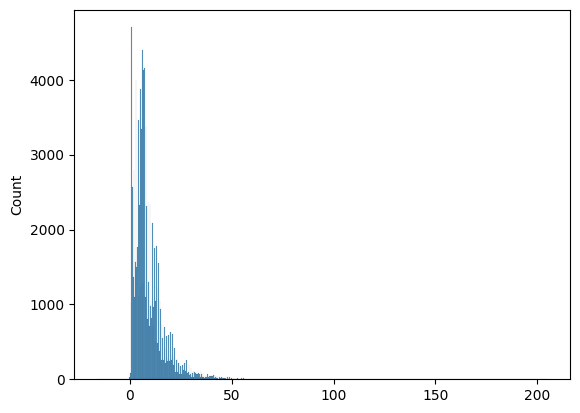

In [22]:
sns.histplot(olist_orders_dataset4['order_delivery_time'].values/np.timedelta64(1, 'D'))

<Axes: ylabel='Count'>

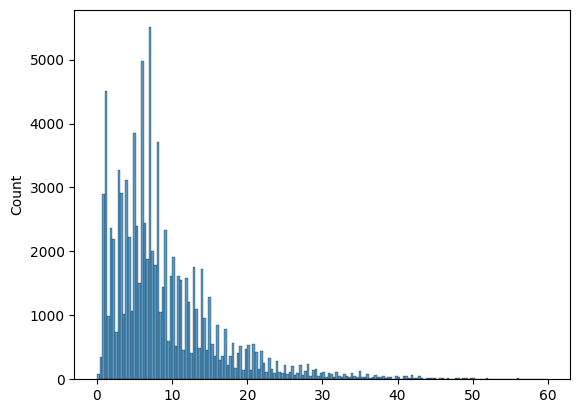

In [23]:
sns.histplot(olist_orders_dataset4['order_delivery_time'].values/np.timedelta64(1, 'D'), binrange=[0,60])

### 4.1.3 Geographic Density Maps

### Number of Sellers

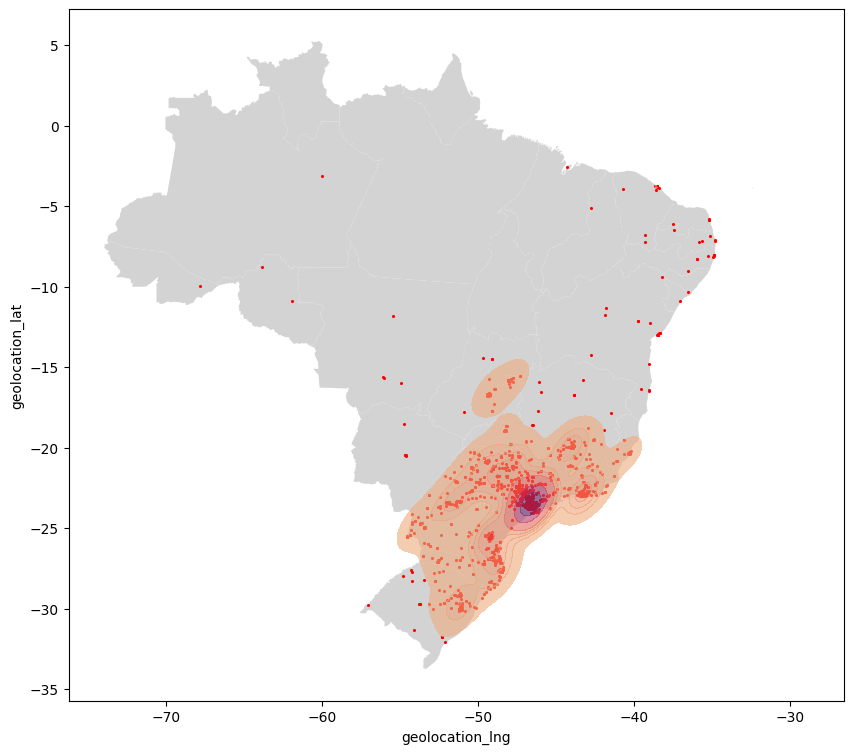

In [24]:
sns.color_palette("rocket_r", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
br_geomap.plot(color="lightgrey",ax=ax)
olist_sellers_dataset4.plot(x='geolocation_lng', y = 'geolocation_lat', kind='scatter', c='red', s=1.5, ax=ax)

kdeplot = sns.kdeplot(
    data=olist_sellers_dataset4,
    x="geolocation_lng",
    y="geolocation_lat",
    levels=8,
    fill=True,
    alpha=0.6,
    cut=2,
    ax=ax,
    cmap='flare',    
)

plt.show()

### Number of Purchases

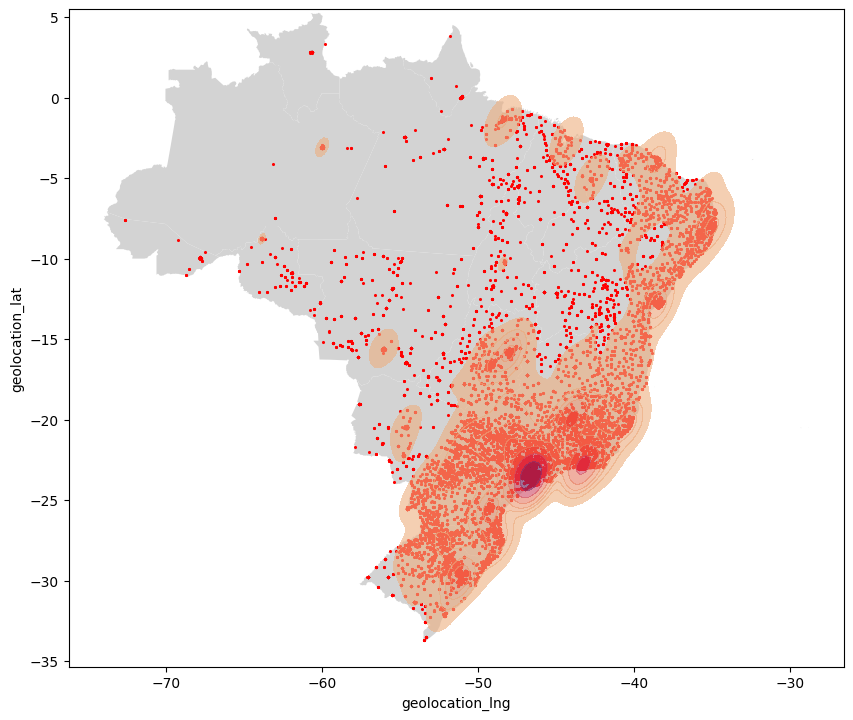

In [25]:
sns.color_palette("rocket_r", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
br_geomap.plot(color="lightgrey",ax=ax)
olist_customers_dataset4.plot(x='geolocation_lng', y = 'geolocation_lat', kind='scatter', c='red', s=1.5, ax=ax)

sns.kdeplot(
    data=olist_customers_dataset4,
    x="geolocation_lng",
    y="geolocation_lat",
    levels=8,
    fill=True,
    alpha=0.6,
    cut=2,
    ax=ax,
    cmap='flare',    
)

plt.show()

## 4.2 Bivariate Analysis

### 4.2.1 Per State

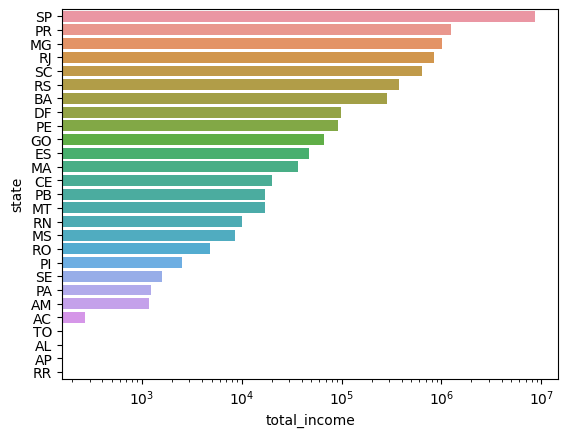

In [26]:
plot_df = states_df4.sort_values(by=['total_income'], ascending=False)
sns.barplot(data=plot_df, x=plot_df['total_income'], y=plot_df['state'])
plt.xscale('log')

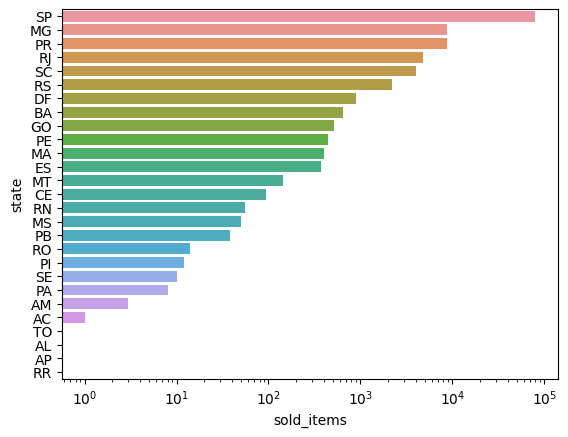

In [27]:
plot_df = states_df4.sort_values(by=['sold_items'], ascending=False)
sns.barplot(data=plot_df, x=plot_df['sold_items'], y=plot_df['state'])
plt.xscale('log')

<Axes: xlabel='bought_items', ylabel='state'>

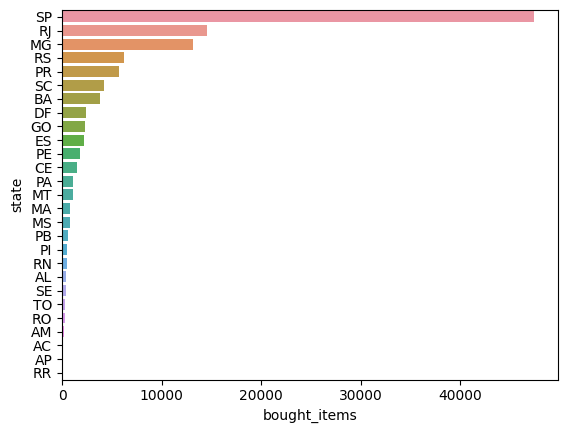

In [28]:
plot_df = states_df4.sort_values(by=['bought_items'], ascending=False)
sns.barplot(data=plot_df, x=plot_df['bought_items'], y=plot_df['state'])

<Axes: xlabel='total_cost', ylabel='state'>

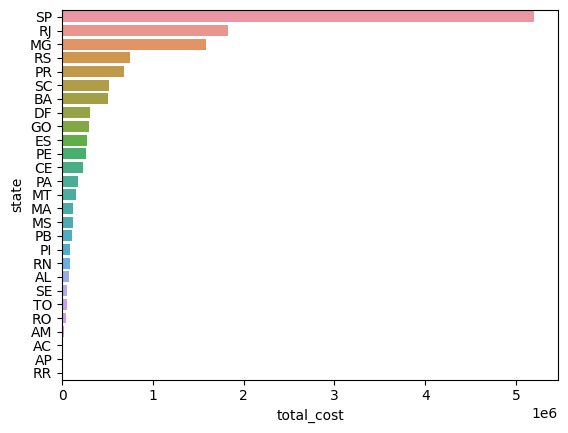

In [29]:
plot_df = states_df4.sort_values(by=['total_cost'], ascending=False)
sns.barplot(data=plot_df, x=plot_df['total_cost'], y=plot_df['state'])

<Axes: ylabel='state'>

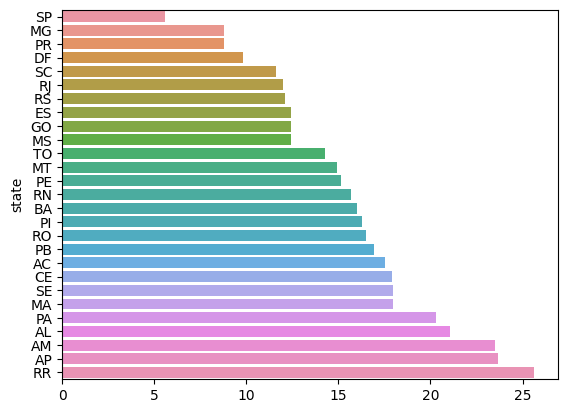

In [30]:
plot_df = states_df4.sort_values(by=['mean_delivery_time'], ascending=True)
sns.barplot(data=plot_df, x=plot_df['mean_delivery_time'].values/np.timedelta64(1, 'D'), y=plot_df['state'])

### 4.2.2 Per City (top20 cities)

<Axes: xlabel='total_income', ylabel='city'>

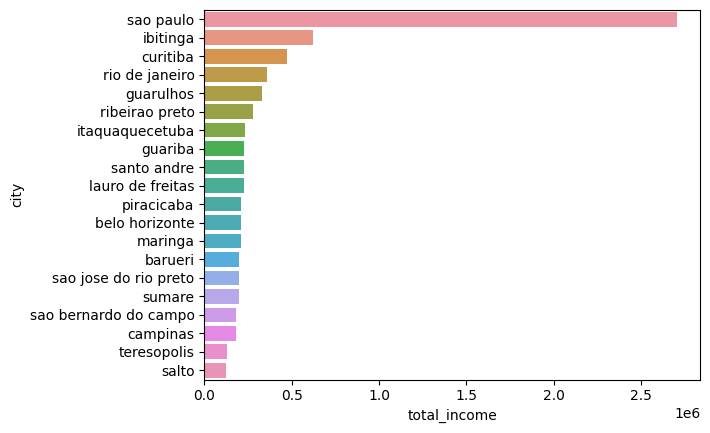

In [31]:
plot_df = cities_df4.sort_values(by=['total_income'], ascending=False)[:20]
sns.barplot(data=plot_df, x=plot_df['total_income'], y=plot_df['city'])

<Axes: xlabel='sold_items', ylabel='city'>

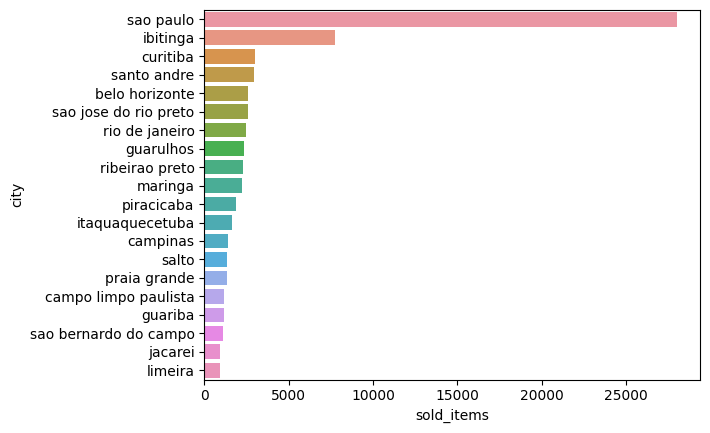

In [32]:
plot_df = cities_df4.sort_values(by=['sold_items'], ascending=False)[:20]
sns.barplot(data=plot_df, x=plot_df['sold_items'], y=plot_df['city'])

<Axes: xlabel='bought_items', ylabel='city'>

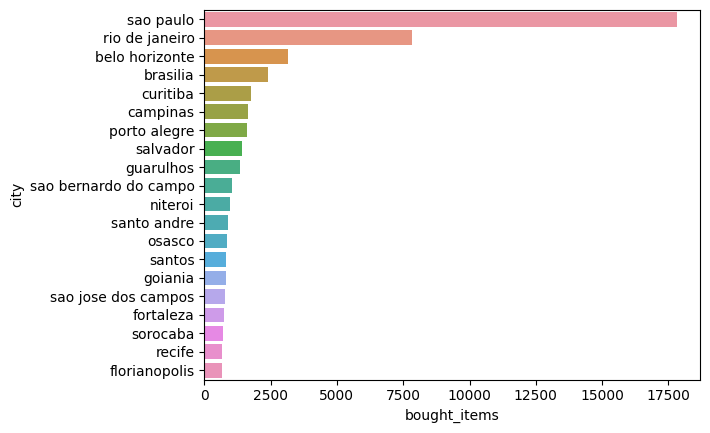

In [33]:
plot_df = cities_df4.sort_values(by=['bought_items'], ascending=False)[:20]
sns.barplot(data=plot_df, x=plot_df['bought_items'], y=plot_df['city'])

<Axes: xlabel='total_cost', ylabel='city'>

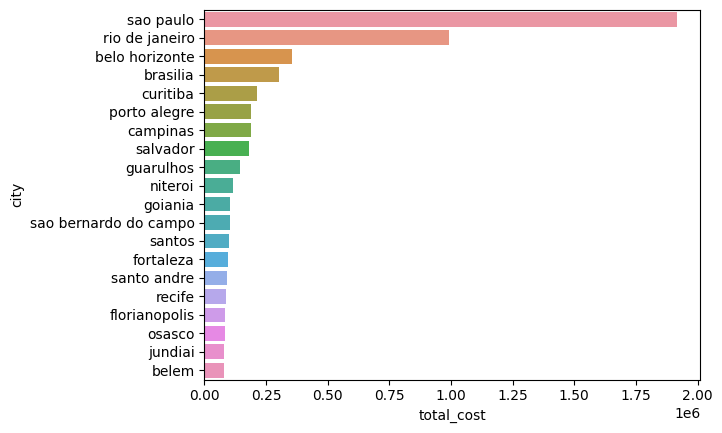

In [34]:
plot_df = cities_df4.sort_values(by=['total_cost'], ascending=False)[:20]
sns.barplot(data=plot_df, x=plot_df['total_cost'], y=plot_df['city'])

### 4.3 Some Early _Insights_

- o estado de SP é responsável por 64,4% da receita gerada na plataforma e 71,3% do total de vendas;
- além disso, também é responsável por 42,1% das compras e 38,2% do valor gasto na plataforma;
- a discrepância entre tempo de entrega de SP e RR, estados com a média de tempo mais rápida e mais demorada, respectivamente, é de cerca de 400%.

# Experimentos

Para futura ref: estamos fazendo uma EDA sobre os datasets a fim de identificar as variáveis de maior relevância/correlação sobre tempo de entrega.
Tal EDA nos dará insights sobre que modelos aplicar para resolver nosso problema de predição.

In [35]:
olist_customers_dataset5 = olist_customers_dataset4.copy()
olist_customers_dataset5.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_customers_dataset5.csv')
olist_orders_dataset5 = olist_orders_dataset4.copy()
olist_orders_dataset5.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_orders_dataset5.csv')
olist_sellers_dataset5 = olist_sellers_dataset4.copy()
olist_sellers_dataset5.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_sellers_dataset5.csv')

In [36]:
olist_order_items_dataset5 = olist_order_items_dataset_raw.copy()
olist_order_items_dataset5.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_order_items_dataset5.csv')
olist_products_dataset5 = olist_products_dataset_raw.copy()
olist_products_dataset5.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'olist_products_dataset5.csv')

In [37]:
delivery_time_df = pd.DataFrame(0, index=np.arange(99441), columns=['customer_geolocation_lat', 'customer_geolocation_lng'])
count = 0

for customer_id in olist_orders_dataset5['customer_id']:
    try:
        aux = olist_customers_dataset5.loc[olist_customers_dataset5['customer_id'] == customer_id].iloc[0]
        customer_geolocation_lat = aux['geolocation_lat']
        customer_geolocation_lng = aux['geolocation_lng']

    except IndexError:
        customer_geolocation_lat = 0
        customer_geolocation_lng = 0             
    
    delivery_time_df.iloc[count]= [customer_geolocation_lat, customer_geolocation_lng]
    count += 1

In [38]:
seller_city_df = pd.DataFrame(0, index=np.arange(99441), columns=['seller_geolocation_lat', 'seller_geolocation_lng'])
count = 0

for order_id in olist_orders_dataset5['order_id']:
    try:
        aux = olist_order_items_dataset5.loc[olist_order_items_dataset5['order_id'] == order_id].iloc[0]
        seller = aux['seller_id']
        
        aux2 = olist_sellers_dataset5.loc[olist_sellers_dataset5['seller_id'] == seller].iloc[0]
        seller_geolocation_lat = aux2['geolocation_lat']
        seller_geolocation_lng = aux2['geolocation_lng']

    except IndexError:
        seller_geolocation_lat = 0
        seller_geolocation_lng = 0

    seller_city_df.iloc[count] = [seller_geolocation_lat, seller_geolocation_lng]
    count += 1

In [39]:
delivery_time_df = pd.concat([olist_orders_dataset5['order_delivery_time'], delivery_time_df], axis=1)
delivery_time_df = pd.concat([olist_orders_dataset5['order_id'], delivery_time_df], axis=1)
delivery_time_df = pd.concat([delivery_time_df, seller_city_df], axis=1)
delivery_time_df.drop(delivery_time_df[delivery_time_df['customer_geolocation_lat'] == 0].index, inplace = True)
delivery_time_df.dropna(subset = ['order_delivery_time'], inplace = True)
delivery_time_df['order_delivery_time'] = delivery_time_df['order_delivery_time'].apply(lambda x: x.days)
delivery_time_df['customer_geolocation'] = list(zip(delivery_time_df.customer_geolocation_lat, delivery_time_df.customer_geolocation_lng))
delivery_time_df['seller_geolocation'] = list(zip(delivery_time_df.seller_geolocation_lat, delivery_time_df.seller_geolocation_lng))
delivery_time_df['distance_km'] = delivery_time_df.apply(lambda row: geopy.distance.distance(row.customer_geolocation, row.seller_geolocation).km, axis=1)

In [40]:
delivery_time_df

,order_id,order_delivery_time,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,customer_geolocation,seller_geolocation,distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,6,-23.574809,-46.587471,-23.680114,-46.452454,"(-23.57480921065843, -46.587471259651394)","(-23.68011442853022, -46.4524537436668)",18.051106
1,53cdb2fc8bc7dce0b6741e2150273451,12,-12.169860,-44.988369,-19.810119,-43.984727,"(-12.169859806853127, -44.988369250768905)","(-19.81011863229108, -43.98472732006267)",852.256379
2,47770eb9100c2d0c44946d9cf07ec65d,9,-16.746337,-48.514624,-21.362358,-48.232976,"(-16.74633718068107, -48.51462382317262)","(-21.36235769739203, -48.232975701561735)",511.820721
3,949d5b44dbf5de918fe9c16f97b45f8a,9,-5.767733,-35.275467,-19.840168,-43.923299,"(-5.767733285303072, -35.275466808694375)","(-19.840168078827364, -43.92329932223438)",1816.652139
4,ad21c59c0840e6cb83a9ceb5573f8159,1,-23.675037,-46.524784,-23.551707,-46.260979,"(-23.675037359389663, -46.524784094929146)","(-23.551706513599484, -46.260979398542325)",30.189028
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,7,-23.178732,-45.889711,-22.957505,-46.524886,"(-23.178732139332883, -45.88971125520799)","(-22.95750491772243, -46.52488623678449)",69.545285
99437,63943bddc261676b46f01ca7ac2f7bd8,20,-24.001467,-46.446355,-21.935321,-50.497562,"(-24.00146687705574, -46.446355136966936)","(-21.93532101918528, -50.49756182976886)",474.239469
99438,83c1379a015df1e13d02aae0204711ab,23,-17.891522,-39.370942,-23.551013,-46.448489,"(-17.891522168784007, -39.37094244016125)","(-23.551013388568272, -46.44848890729416)",967.147828
99439,11c177c8e97725db2631073c19f07b62,13,-22.555985,-42.690761,-20.944706,-45.827098,"(-22.55598517198416, -42.6907612914232)","(-20.944705621834668, -45.82709818233235)",370.231030


In [41]:
corr = delivery_time_df.corr(method='spearman', numeric_only=True)
corr

,order_delivery_time,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,distance_km
order_delivery_time,1.000000,0.297496,0.099002,0.106146,-0.095066,0.612646
customer_geolocation_lat,0.297496,1.000000,0.439861,0.068281,0.064166,0.429109
customer_geolocation_lng,0.099002,0.439861,1.000000,0.061973,0.066668,0.102928
seller_geolocation_lat,0.106146,0.068281,0.061973,1.000000,0.067779,0.082020
seller_geolocation_lng,-0.095066,0.064166,0.066668,0.067779,1.000000,-0.140956
distance_km,0.612646,0.429109,0.102928,0.082020,-0.140956,1.000000


In [42]:
# product_cat_df = pd.DataFrame(0, index=np.arange(96193), columns=olist_products_dataset5['product_category_name'].unique())
# count = 0

# for order_id in delivery_time_df['order_id']:
#     indices_array = np.where(olist_order_items_dataset5['order_id'] == order_id)
#     products_id_array = olist_order_items_dataset5.iloc[indices_array]['product_id'].values
#     zero_array = np.zeros(74)
    
#     for product_id in products_id_array:
#         aux = olist_products_dataset5.loc[olist_products_dataset5['product_id'] == product_id]
#         product_category = aux['product_category_name'].values[0]        
#         index = np.where(product_cat_df.columns == product_category)
#         zero_array[index] = 1

#     product_cat_df.iloc[count] = zero_array
#     count +=1

# product_cat_df = pd.concat([delivery_time_df['order_delivery_time'].reset_index(drop=True), product_cat_df], axis=1)

In [43]:
# weight_array = []

# for order_id in delivery_time_df['order_id']:
#     indices_array = np.where(olist_order_items_dataset5['order_id'] == order_id)
#     products_id_array = olist_order_items_dataset5.iloc[indices_array]['product_id'].values
#     product_indexes_array = np.where(olist_products_dataset5.isin({'product_id':products_id_array}) == True)[0]
#     weights = olist_products_dataset5.iloc[product_indexes_array]['product_weight_g']
#     total_weight = np.sum(weights)    
#     weight_array.append(total_weight)

# total_weight = pd.Series(weight_array, name='total_weight')
# total_weight_df = pd.concat([delivery_time_df['order_delivery_time'].reset_index(drop=True), total_weight], axis=1)

<Axes: xlabel='distance_km', ylabel='order_delivery_time'>

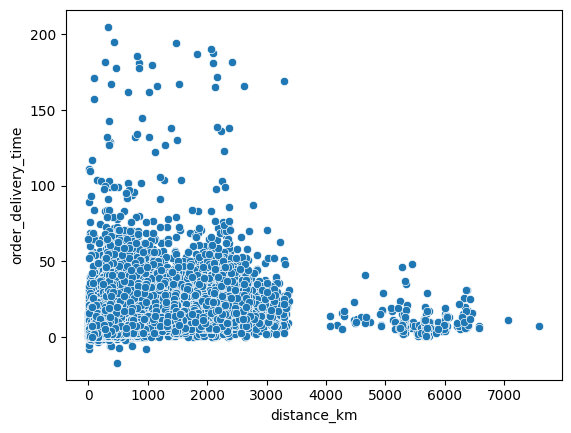

In [44]:
sns.scatterplot(data=delivery_time_df, x="distance_km", y="order_delivery_time")

In [50]:
a = delivery_time_df.loc[delivery_time_df['distance_km'] < 1000]['order_delivery_time']

In [53]:
print(np.mean(a), np.var(a))

7.6431892287283505 58.39639700470874


<Axes: xlabel='order_delivery_time'>

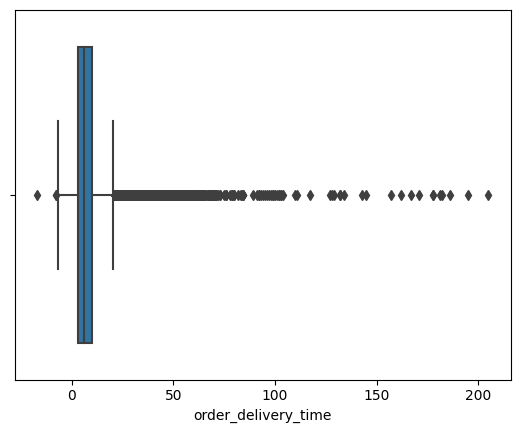

In [52]:
sns.boxplot(data=delivery_time_df.loc[delivery_time_df['distance_km'] < 1000], x='order_delivery_time')

In [54]:
b = delivery_time_df.loc[delivery_time_df['distance_km'] > 3600]['order_delivery_time']

In [55]:
print(np.mean(b), np.var(b))

9.672811059907835 60.70861560024633


<Axes: xlabel='order_delivery_time'>

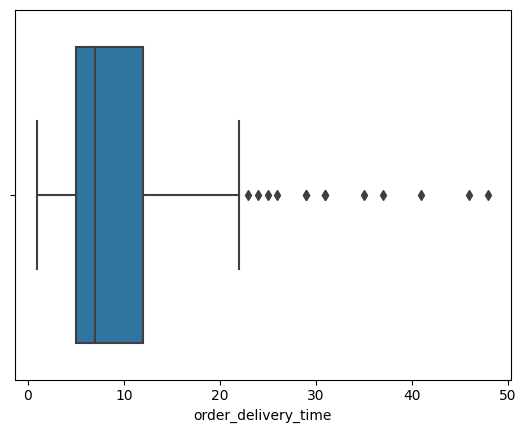

In [59]:
sns.boxplot(data=delivery_time_df.loc[delivery_time_df['distance_km'] > 3600], x='order_delivery_time')

In [57]:
big_distance_group = delivery_time_df.loc[delivery_time_df['distance_km'] > 3600]

In [62]:
X = np.reshape(big_distance_group['distance_km'], (-1, 1))
y = big_distance_group['order_delivery_time']

In [63]:
reg = LinearRegression().fit(X, y)

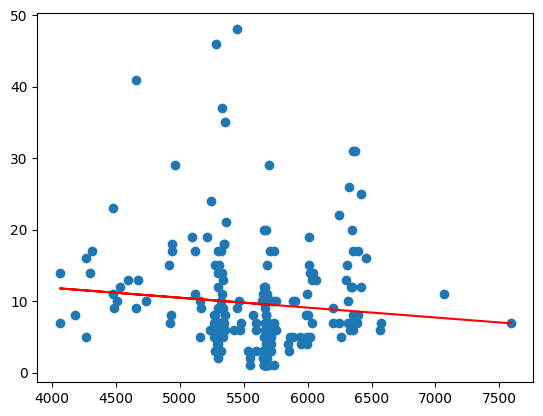

In [79]:
fig, ax1 = plt.subplots()
ax1.scatter(X, y)
ax1.plot(X,reg.predict(X), color='red')
plt.show()

# Próximos Passos

- normalização
- padronização

# 5.0 Data Preparation

## 5.1 Normalization

## 5.2 Standardization

## 5.3 Transformations

# 6.0 Feature Selection

## 6.1 Sets Selection

## 6.2 Variable Selection

boruta ou manual

# 7.0 ML Models

# 8.0 Model Fine-tuning

# 9.0 Model Testing 

# 10.0 Deploy